In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset,DataLoader
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from Models import *
from DDBSCAN import Raster_DBSCAN
import matplotlib.colors as mcolors
from collections import defaultdict
import time
# set times new roman font to use in matplotlib
plt.rcParams["font.family"] = "Times New Roman"
seed = 414
# np.random.seed(seed)
colors = np.random.rand(600, 3)
colors = np.concatenate([np.array([[0,0,0]]),colors],axis = 0)
colormap = mcolors.ListedColormap(colors)

In [2]:
patience = 5 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 4
lane_unit = 200
time_span = 100
hidden_size = 256
num_layers = 2
input_size = lane_unit
learning_rate = 0.001
num_epochs = 50
best_model = BidirectionalLSTMLaneReconstructor(input_size, hidden_size, num_layers).to(device)
# best_model = UnidirectionalLSTMLaneReconstructor(input_size, hidden_size, num_layers).to(device)
# criterion = RangeWeightedBCELoss()
# criterion = FocalLoss()
# criterion = sigmoid_focal_loss(reduction='mean')
mocel_save_path = r"D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0914_5res_lanechange_signal\models\train_2"
if not os.path.exists(mocel_save_path):
    os.makedirs(mocel_save_path)
model_name = f'checkpoint_6.pth'
best_model.load_state_dict(torch.load(os.path.join(mocel_save_path, model_name),weights_only=False))
best_model.eval()
db = Raster_DBSCAN(Td_map_szie=(lane_unit,time_span), window_size=[7,13],eps = 1,min_samples=3)

## Plot Stats of Validation Dataset

In [ ]:
val_dataset = TrajDataset(r"D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0914_5res_lanechange_signal\100_frame\val",time_span)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# find out the number of 1 over the total number of elements
positive_ratio = []
for batch in tqdm(val_loader):
    post_occ_X = batch['post_occ_X'].to(device)
    target = batch['target'].to(device)
    speed = batch['speed_target'].to(device)
    positive_ratio.append(np.float32(((target == 1).sum() / target.numel()).cpu().numpy())) 

vehicle_nums = []
vehicle_speed = []
batch_count = 0
for batch in tqdm(val_loader):
    post_occ_X = batch['post_occ_X'].to(device)
    target = batch['target'].to(device)
    speed = batch['speed_target'].to(device)
    traj_id = batch['traj_id']
    vehicle_nums.append(len(np.unique(traj_id))-1)
    # find mask where target is 1 and speed is not 0 and target is 1 and speed is 0
    mask = (target == 1) & (speed != 0)
    speeds = speed[mask].cpu().numpy()
    vehicle_speed.append(speeds)
    if batch_count >  2000:
        break
    batch_count += 1 
    # find the number of elements in mask

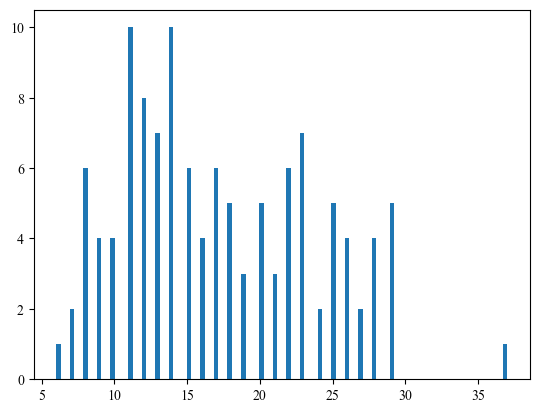

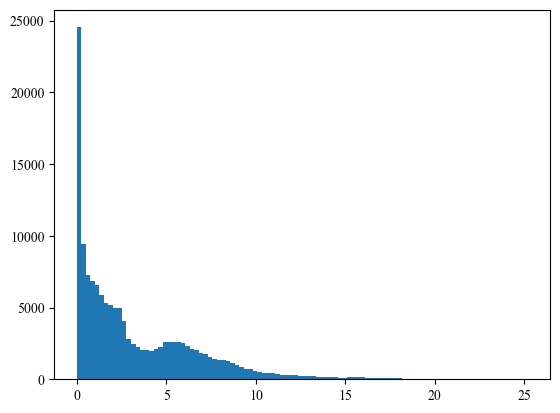

In [6]:
# freeflow
plt.hist(vehicle_nums,bins = 100)
plt.show()
# flatten all items in the speed list
vehicle_speed = np.concatenate(vehicle_speed)
plt.hist(vehicle_speed,bins = 100)
plt.show()

## Plot a prediction result from validation set

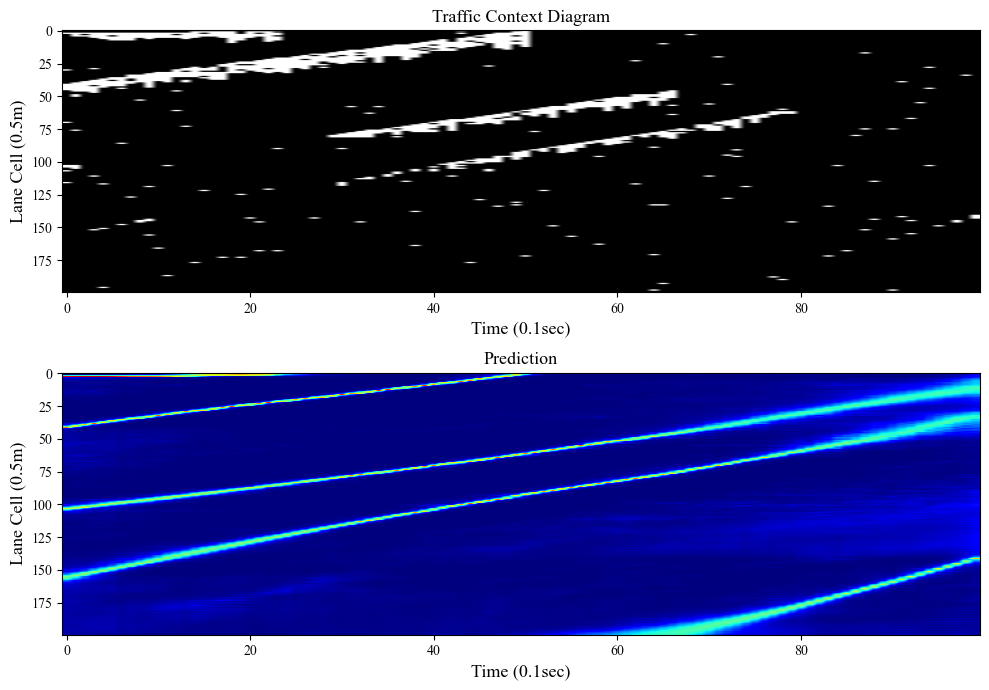

In [9]:
data = val_dataset[35]
post_occ_X = data['post_occ_X']
target = data['target']
speed = data['speed_target']
traj_id = data['traj_id']
# make traj_id upside down
traj_id = np.flipud(traj_id)

output = best_model(post_occ_X.unsqueeze(0).to(device))
numpy_ouput = output.squeeze(0).detach().cpu().numpy()
# post_occ_X.shape
post_occ_X = post_occ_X.squeeze(0).detach().cpu().numpy()

fig, axs = plt.subplots(2, 1, figsize=(10, 7))

# Pseudo Time-Space Diagram
axs[0].imshow(post_occ_X, cmap='gray', aspect='auto')
axs[0].set_title('Traffic Context Diagram',fontsize = 13)
axs[0].set_xlabel('Time (0.1sec)',fontsize = 13)
axs[0].set_ylabel('Lane Cell (0.5m)',fontsize = 13)
# fontsize
axs[0].tick_params(axis='both', which='major', labelsize=10)

# Prediction
axs[1].imshow(numpy_ouput, cmap='jet', aspect='auto')
axs[1].set_title('Prediction',fontsize = 13)
axs[1].set_xlabel('Time (0.1sec)',fontsize = 13)
axs[1].set_ylabel('Lane Cell (0.5m)',fontsize = 13)
axs[1].tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
# plt.savefig('D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\Figuresprediction.png',dpi = 300)
plt.show()


## Generate individule trajectories

In [ ]:
lane_unit = 200
time_span = 100
db = Raster_DBSCAN(Td_map_szie=(lane_unit,time_span), window_size=[3,13],eps = 1,min_samples=3)
pred_trajectories = numpy_ouput > 0.35
Labels = db.fit_predict(pred_trajectories, pred_trajectories)
num_lane_units, time_span = numpy_ouput.shape
# Create a dictionary to store the (x,t) profiles for each label
trajectories_output = defaultdict(list)
for t in range(time_span):
    Labels_t = Labels[:,t]
    unique_id, xs, counts = np.unique(Labels_t,return_index=True,return_counts=True)
    center_locations = xs + counts / 2
    if unique_id[0] == -1:
        unique_id = unique_id[1:]
        center_locations = center_locations[1:]
    for i, label in enumerate(unique_id):
        trajectories_output[label].append((t,center_locations[i]))
# calculate speed for each trajectory
speed_output = []
for traj in trajectories_output.values():
    t, x = zip(*traj)
    t = np.array(t)
    x = np.array(x)
    speed = -np.diff(x) * 0.5 / (0.1 * np.diff(t))
    speed_output.append(speed)
trajectories_label = defaultdict(list)
# extract from speed and trajecotry id using same method
for t in range(time_span):
    Labels_t = Labels[:,t]
    unique_id, xs, counts = np.unique(Labels_t,return_index=True,return_counts=True)
    center_locations = xs
    # extract speed
    if unique_id[0] == -1:
        unique_id = unique_id[1:]
        center_locations = center_locations[1:]
    for i, label in enumerate(unique_id):
        trajectories_label[label].append((t,center_locations[i]))
speed_label = []
for traj in trajectories_label.values():
    t, x = zip(*traj)
    t = np.array(t)
    x = np.array(x)
    speed = -np.diff(x) * 0.5 / (0.1 * np.diff(t))
    speed_label.append(speed)


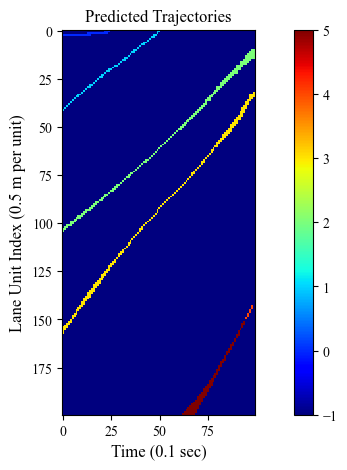

In [16]:
plt.figure(figsize=(10, 5))
plt.imshow(Labels, cmap='jet', interpolation='none')
plt.title('Predicted Trajectories', fontsize=12)
plt.xlabel('Time (0.1 sec)', fontsize=12)
plt.ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
plt.colorbar()
plt.show()


## Generate Trajectories from real data

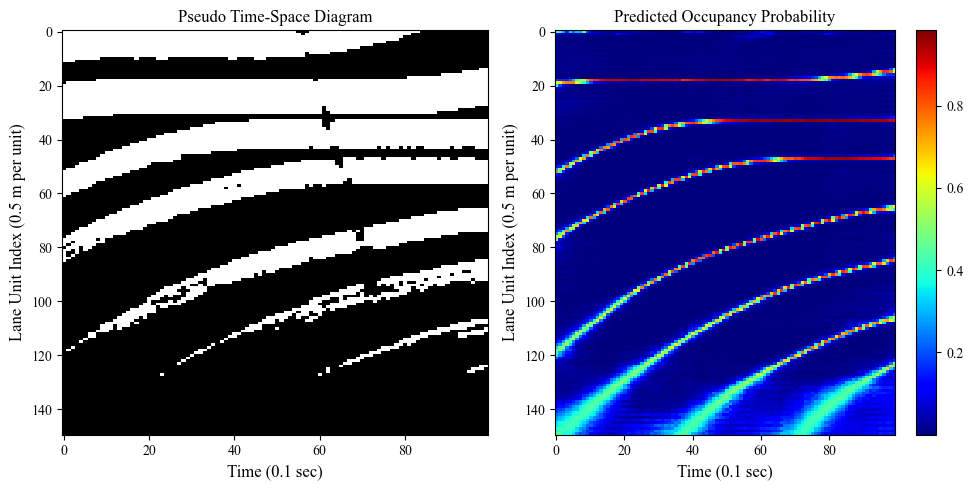

In [19]:
lane_unit_num = 200
test_diagram = np.load(r"D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5_2300\lane_2.npy")
# make it upside down
test_diagram = np.flipud(test_diagram)
# pad zeros to make it 200 x-1
original_shape = test_diagram.shape
padding = np.zeros((lane_unit_num - test_diagram.shape[0], test_diagram.shape[1]))
test_diagram = np.concatenate((test_diagram,padding), axis=0)
start_frame = 300
end_frame = start_frame + time_span
test_snippet = test_diagram[:,start_frame:end_frame]
with torch.no_grad():
    input_snippet = torch.from_numpy(test_snippet).float().to(device)
    input_snippet = input_snippet.unsqueeze(0)
    output = best_model(input_snippet)
    output = output.squeeze(0).cpu().numpy()
# only within 100 units are trustable
output = output[:150]
test_snippet = test_snippet[:150]
# plot input_snippet and output
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(test_snippet, cmap='gray',aspect='auto', interpolation='none')
axs[0].set_title('Pseudo Time-Space Diagram', fontsize=12)
axs[0].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[0].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[1].imshow(output, cmap='jet',aspect='auto', interpolation='none')
axs[1].set_title('Predicted Occupancy Probability', fontsize=12)
axs[1].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[1].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
fig.colorbar(axs[1].images[0], ax=axs[1])
plt.tight_layout()
plt.show()


In [ ]:
lane_unit_num = 200
test_diagram = np.load(r"D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5_0430\lane_2.npy")
# make it upside down
test_diagram = np.flipud(test_diagram)
# pad zeros to make it 200 x-1
original_shape = test_diagram.shape
padding = np.zeros((lane_unit_num - test_diagram.shape[0], test_diagram.shape[1]))
test_diagram = np.concatenate((test_diagram,padding), axis=0)
stride = 30
systhesis_diagram = np.zeros_like(test_diagram,dtype = np.float32)
time_efficiency_ms_LSTM = []
for start_frame in tqdm(range(0, test_diagram.shape[1] - time_span,1)):
    end_frame = start_frame + time_span
    test_snippet = test_diagram[:,start_frame:end_frame]
    with torch.no_grad():
        input_snippet = torch.from_numpy(test_snippet).float().to(device)
        input_snippet = input_snippet.unsqueeze(0)
        # make it a batch of size 11
        input_snippet = input_snippet.repeat(11,1,1)
        # break
        time_a = time.time()
        output = best_model(input_snippet)
        time_b = time.time()
        output = output.squeeze(0).cpu().numpy()
    
        # systhesis_diagram[:,start_frame:end_frame] += output
    time_efficiency_ms_LSTM.append((time_b-time_a)*1000)

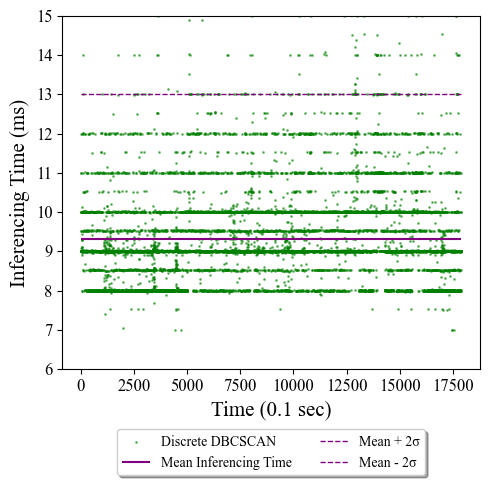

In [ ]:
mean_time = np.mean(time_efficiency_ms_LSTM)
std_time = np.std(time_efficiency_ms_LSTM)
plt.figure(figsize = (5,5))
plt.scatter(range(len(time_efficiency_ms_LSTM)),time_efficiency_ms_LSTM ,label = 'Discrete DBCSCAN', s = 1, c = 'g',alpha = 0.5)

plt.hlines(mean_time,0,len(time_efficiency_ms_LSTM),color = 'purple',label = 'Mean Inferencing Time')
plt.hlines(mean_time + 2 * std_time,0,len(time_efficiency_ms_LSTM),color = 'purple',linestyles = '--',label = 'Mean + 2σ', linewidth = 1)
plt.hlines(mean_time - 2 * std_time,0,len(time_efficiency_ms_LSTM),color = 'purple',linestyles = '--',label = 'Mean - 2σ', linewidth = 1)

#plot legend outside the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylim(6,15)
plt.xlabel('Time (0.1 sec)',fontsize = 15)
plt.ylabel('Inferencing Time (ms)',fontsize = 15)
# plt.title('Inferencing Time of Discrete DBSCAN',fontsize = 15)
plt.tight_layout()
# plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\ModelInferencing.png',bbox_inches='tight',dpi = 300)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)

plt.show()

In [ ]:
import time
thred = 5
systhesis_diagram[150:] = 0
binary_map = systhesis_diagram > thred
db = Raster_DBSCAN(Td_map_szie=(200,100*11), window_size=[3,13],eps = 1,min_samples=1)
time_efficiency_ms_DDBSCAN = []
for i in tqdm(range(0, systhesis_diagram.shape[1] - time_span)):
    # make a large snippet with (200, 100 * 11)
    systhesis_diagram_snippet = systhesis_diagram[:,i:i+time_span]
    systhesis_diagram_snippet_larger = np.zeros((200, 100 * 11))
    for j in range(11):
        systhesis_diagram_snippet_larger[:,j*100:(j+1)*100] = systhesis_diagram_snippet
    time_a = time.time()
    Labels = db.fit_predict(systhesis_diagram_snippet_larger > thred,Foreground_map=systhesis_diagram_snippet_larger > thred)
    time_b = time.time()
    time_efficiency_ms_DDBSCAN.append((time_b - time_a) * 1000)
time_efficiency_ms_DDBSCAN = np.array(time_efficiency_ms_DDBSCAN) * 5 # 5 is the factor from individual frame processing to batch processing


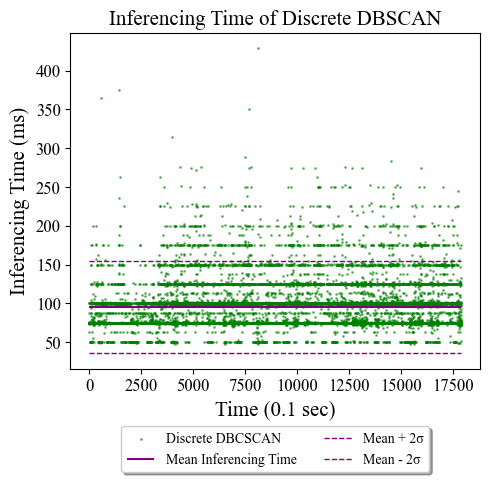

In [80]:
mean_time = np.mean(time_efficiency_ms)
std_time = np.std(time_efficiency_ms)
plt.figure(figsize = (5,5))
plt.scatter(range(len(time_efficiency_ms)),time_efficiency_ms ,label = 'Discrete DBCSCAN', s = 1, c = 'g',alpha = 0.5)

plt.hlines(mean_time,0,len(time_efficiency_ms),color = 'purple',label = 'Mean Inferencing Time')
plt.hlines(mean_time + 2 * std_time,0,len(time_efficiency_ms),color = 'purple',linestyles = '--',label = 'Mean + 2σ', linewidth = 1)
plt.hlines(mean_time - 2 * std_time,0,len(time_efficiency_ms),color = 'purple',linestyles = '--',label = 'Mean - 2σ', linewidth = 1)

#plot legend outside the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
# plt.ylim(0,12)
plt.xlabel('Time (0.1 sec)',fontsize = 15)
plt.ylabel('Inferencing Time (ms)',fontsize = 15)
plt.title('Inferencing Time of Discrete DBSCAN',fontsize = 15)
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\DDBSCAN_inferencing.png',bbox_inches='tight',dpi = 300)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)

plt.show()

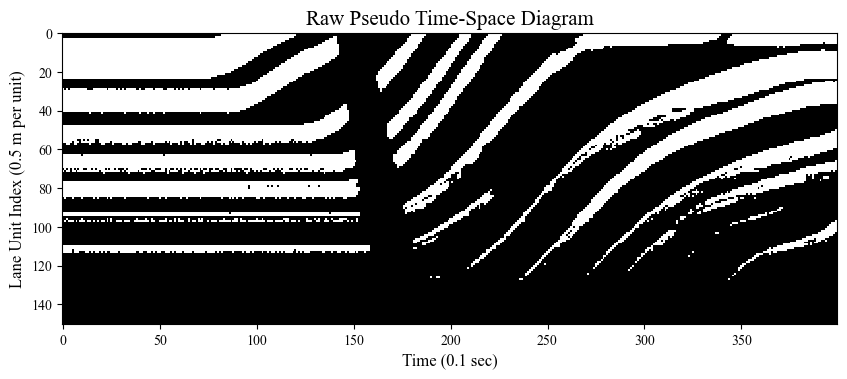

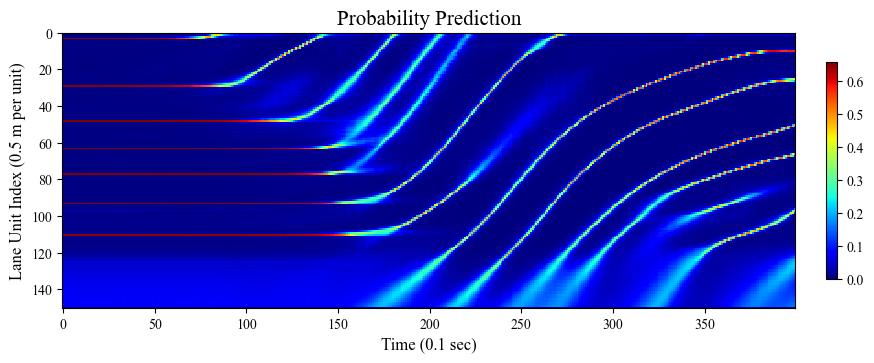

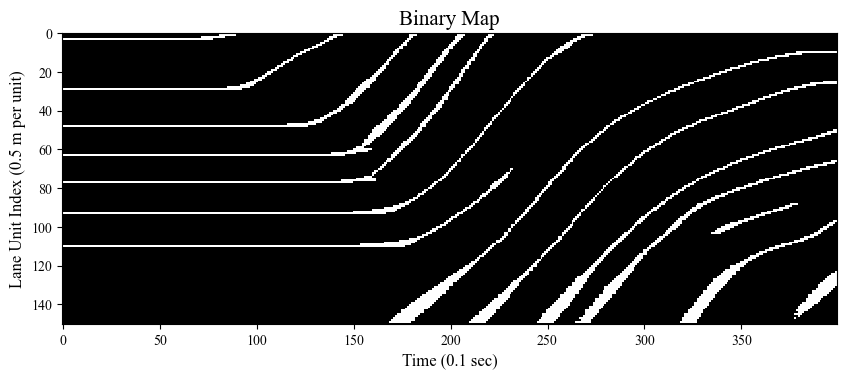

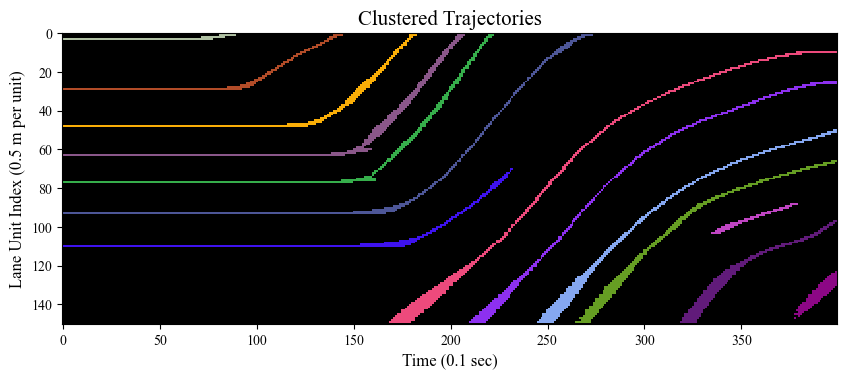

In [47]:
start_frame = 2300
end_frame = start_frame + 400
plt.figure(figsize=(10, 5))
plt.imshow(test_diagram[:,start_frame:end_frame], cmap='gray', interpolation='none')
plt.ylim(150,0)
plt.title('Raw Pseudo Time-Space Diagram', fontsize=15)
plt.xlabel('Time (0.1 sec)', fontsize=12)
plt.ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\RawPseudoTimeSpaceDiagram.png',dpi = 300,bbox_inches='tight')
plt.show()
plt.figure(figsize=(10, 5))
plt.imshow(systhesis_diagram[:,start_frame:end_frame]/30, cmap='jet', interpolation='none')
plt.ylim(150,0)
plt.title('Probability Prediction', fontsize=15)
plt.xlabel('Time (0.1 sec)', fontsize=12)
plt.ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
# add colorbar, with the same height as the image
plt.colorbar(fraction=0.014, pad=0.04)
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\ProbabilityPrediction.png',dpi = 300,bbox_inches='tight')
plt.show()
plt.figure(figsize=(10, 5))
plt.imshow(binary_map[:,start_frame:end_frame], cmap='gray',interpolation='none')
plt.ylim(150,0)
plt.title('Binary Map', fontsize=15)
plt.xlabel('Time (0.1 sec)', fontsize=12)
plt.ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\BinaryMap.png',dpi = 300,bbox_inches='tight')
plt.show()
plt.figure(figsize=(10, 5))
plt.imshow(Labels[:,start_frame:end_frame], cmap=colormap, interpolation='none')
plt.ylim(150,0)
plt.title('Clustered Trajectories', fontsize=15)
plt.xlabel('Time (0.1 sec)', fontsize=12)
plt.ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\ClusteredTrajectories.png',dpi = 300,bbox_inches='tight')
plt.show()

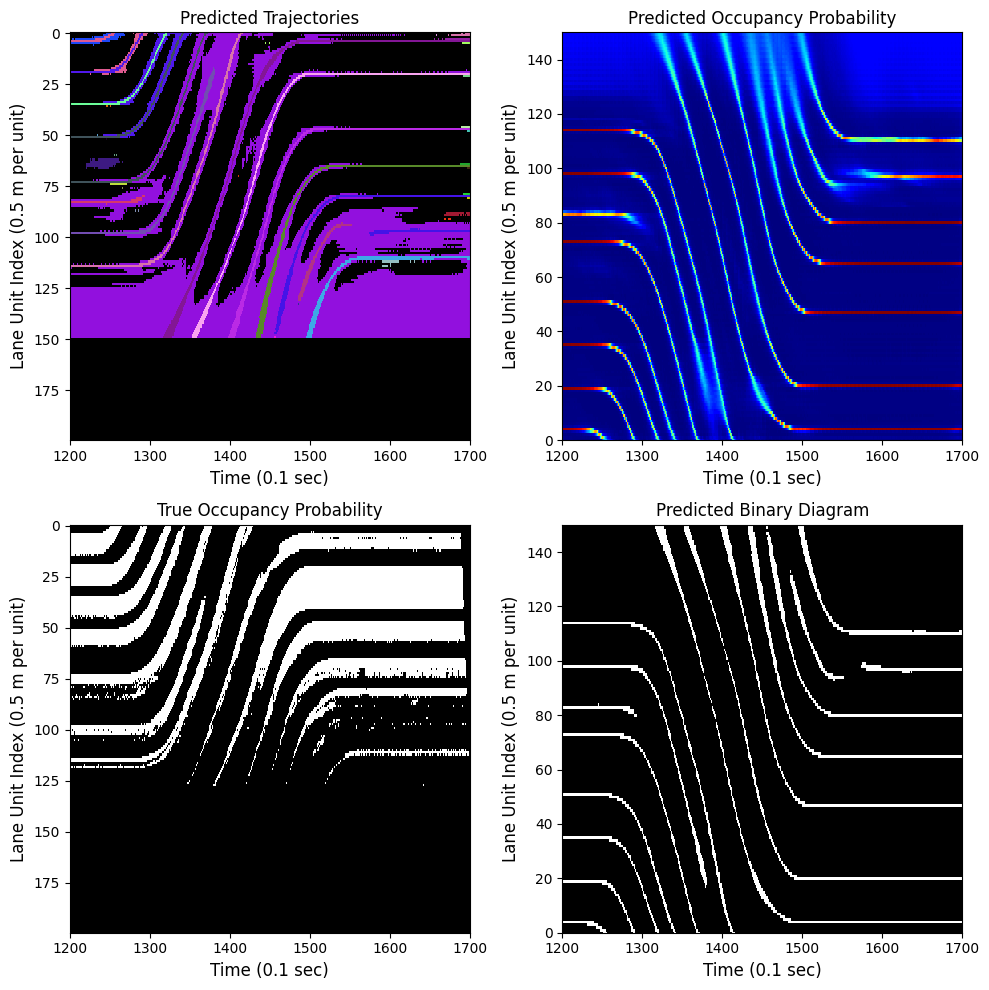

In [11]:
thred = 5
systhesis_diagram[150:] = 0
db = Raster_DBSCAN(Td_map_szie=systhesis_diagram.shape, window_size=[3,13],eps = 1,min_samples=1)
Labels = db.fit_predict(systhesis_diagram > thred,Foreground_map=systhesis_diagram > thred)


start_frame = 1200
end_frame = start_frame + 500
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].imshow(Labels, cmap=colormap, interpolation='none',aspect='auto')
axs[0,0].set_title('Predicted Trajectories', fontsize=12)
axs[0,0].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[0,0].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[0,0].set_xlim([start_frame,end_frame])
axs[0,1].imshow(systhesis_diagram, cmap='jet', interpolation='none',aspect='auto')
axs[0,1].set_title('Predicted Occupancy Probability', fontsize=12)
axs[0,1].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[0,1].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[0,1].set_xlim([start_frame,end_frame])
axs[0,1].set_ylim([0,150])
axs[1,0].imshow(test_diagram, cmap='gray', interpolation='none',aspect='auto')
axs[1,0].set_title('True Occupancy Probability', fontsize=12)
axs[1,0].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[1,0].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[1,0].set_xlim([start_frame,end_frame])
axs[1,1].imshow(systhesis_diagram > thred, cmap='gray', interpolation='none',aspect='auto')
axs[1,1].set_title('Predicted Binary Diagram', fontsize=12)
axs[1,1].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[1,1].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[1,1].set_xlim([start_frame,end_frame])
axs[1,1].set_ylim([0,150])

plt.tight_layout()
# plt.savefig(r"D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\check10.png",dpi = 300)
plt.show()

In [9]:
lane_unit_num = 200
test_diagram = np.load(r"D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\lane_2.npy")
# make it upside down
test_diagram = np.flipud(test_diagram)
# pad zeros to make it 200 x-1
original_shape = test_diagram.shape
padding = np.zeros((lane_unit_num - test_diagram.shape[0], test_diagram.shape[1]))
test_diagram = np.concatenate((test_diagram,padding), axis=0)
stride = 1
systhesis_diagram = np.zeros_like(test_diagram,dtype = np.float32)
for start_frame in tqdm(range(0, test_diagram.shape[1] - time_span,5)):
    end_frame = start_frame + time_span
    test_snippet = test_diagram[:,start_frame:end_frame]
    with torch.no_grad():
        input_snippet = torch.from_numpy(test_snippet).float().to(device)
        input_snippet = input_snippet.unsqueeze(0)
        output = best_model(input_snippet)
        output = output.squeeze(0).cpu().numpy()
        systhesis_diagram[:,start_frame:end_frame] += output

100%|██████████| 3578/3578 [00:32<00:00, 111.50it/s]


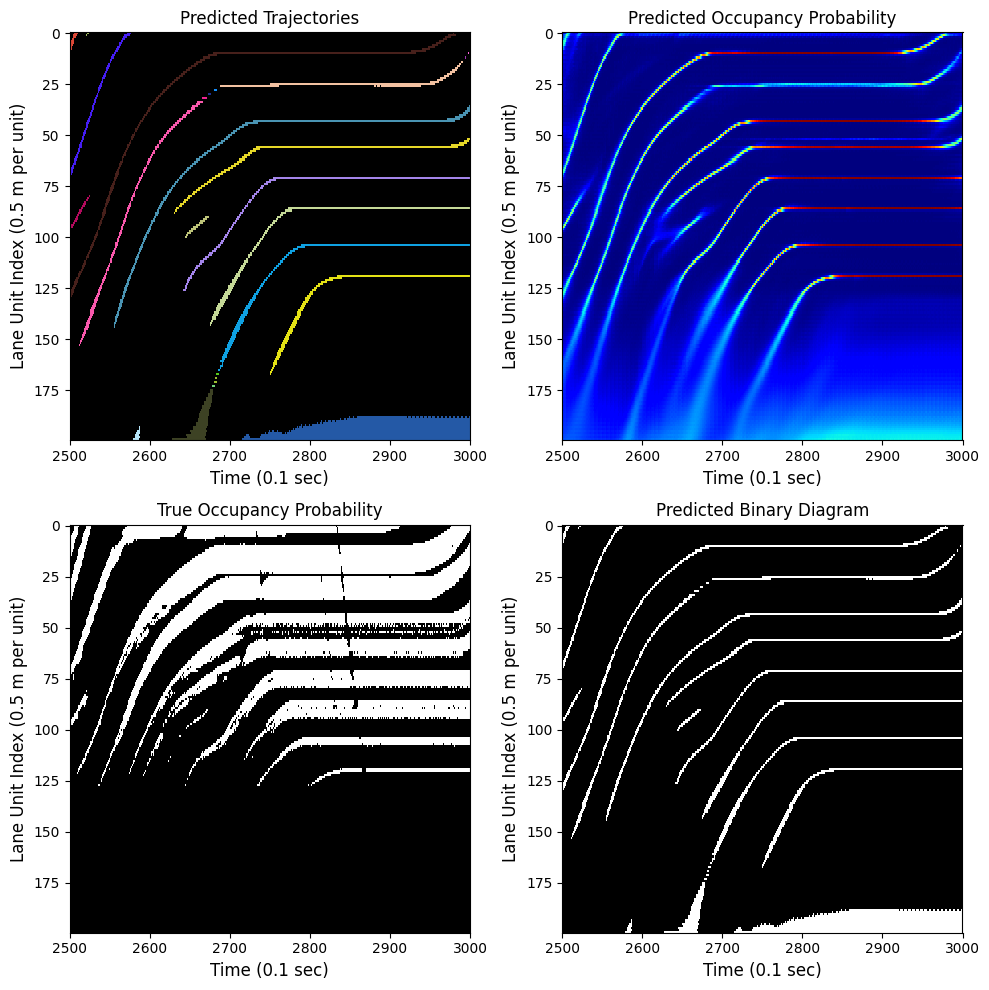

In [12]:
thred = 5
db = Raster_DBSCAN(Td_map_szie=systhesis_diagram.shape, window_size=[3,13],eps = 1,min_samples=1)
Labels = db.fit_predict(systhesis_diagram > thred,Foreground_map=systhesis_diagram > thred)
# plot Labels, systhesis_diagram, test_diagram, pred binary diagram in subplots (2,2)
start_frame = 2500
end_frame = start_frame + 500
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].imshow(Labels, cmap=colormap, interpolation='none',aspect='auto')
axs[0,0].set_title('Predicted Trajectories', fontsize=12)
axs[0,0].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[0,0].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[0,0].set_xlim([start_frame,end_frame])
axs[0,1].imshow(systhesis_diagram, cmap='jet', interpolation='none',aspect='auto')
axs[0,1].set_title('Predicted Occupancy Probability', fontsize=12)
axs[0,1].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[0,1].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[0,1].set_xlim([start_frame,end_frame])
axs[1,0].imshow(test_diagram, cmap='gray', interpolation='none',aspect='auto')
axs[1,0].set_title('True Occupancy Probability', fontsize=12)
axs[1,0].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[1,0].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[1,0].set_xlim([start_frame,end_frame])
axs[1,1].imshow(systhesis_diagram > thred, cmap='gray', interpolation='none',aspect='auto')
axs[1,1].set_title('Predicted Binary Diagram', fontsize=12)
axs[1,1].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[1,1].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[1,1].set_xlim([start_frame,end_frame])
plt.tight_layout()
# plt.savefig(r"D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\check10.png",dpi = 300)
plt.show()

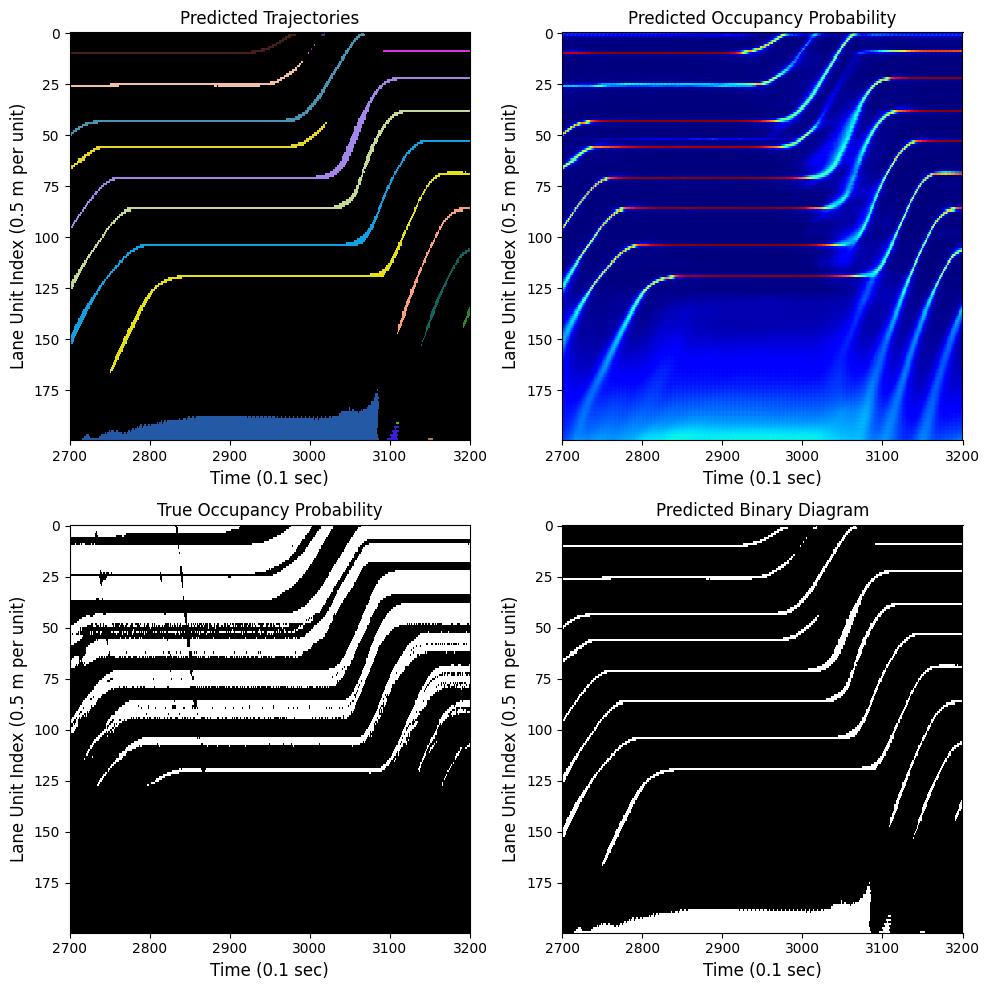

In [14]:
# thred = 5
# db = Raster_DBSCAN(Td_map_szie=systhesis_diagram.shape, window_size=[3,13],eps = 1,min_samples=1)
# Labels = db.fit_predict(systhesis_diagram > thred,Foreground_map=systhesis_diagram > thred)
# plot Labels, systhesis_diagram, test_diagram, pred binary diagram in subplots (2,2)
start_frame = 2700
end_frame = start_frame + 500
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].imshow(Labels, cmap=colormap, interpolation='none',aspect='auto')
axs[0,0].set_title('Predicted Trajectories', fontsize=12)
axs[0,0].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[0,0].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[0,0].set_xlim([start_frame,end_frame])
axs[0,1].imshow(systhesis_diagram, cmap='jet', interpolation='none',aspect='auto')
axs[0,1].set_title('Predicted Occupancy Probability', fontsize=12)
axs[0,1].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[0,1].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[0,1].set_xlim([start_frame,end_frame])
axs[1,0].imshow(test_diagram, cmap='gray', interpolation='none',aspect='auto')
axs[1,0].set_title('True Occupancy Probability', fontsize=12)
axs[1,0].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[1,0].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[1,0].set_xlim([start_frame,end_frame])
axs[1,1].imshow(systhesis_diagram > thred, cmap='gray', interpolation='none',aspect='auto')
axs[1,1].set_title('Predicted Binary Diagram', fontsize=12)
axs[1,1].set_xlabel('Time (0.1 sec)', fontsize=12)
axs[1,1].set_ylabel('Lane Unit Index (0.5 m per unit)', fontsize=12)
axs[1,1].set_xlim([start_frame,end_frame])
plt.tight_layout()
# plt.savefig(r"D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\check10.png",dpi = 300)
plt.show()

In [91]:
num_lane_units, time_span = systhesis_diagram.shape
# Create a dictionary to store the (x,t) profiles for each label
trajectories_output = defaultdict(list)
for t in range(time_span):
    Labels_t = Labels[:,t]
    unique_id, xs, counts = np.unique(Labels_t,return_index=True,return_counts=True)
    center_locations = xs + counts / 2
    if unique_id[0] == -1:
        unique_id = unique_id[1:]
        center_locations = center_locations[1:]
    for i, label in enumerate(unique_id):
        trajectories_output[label].append((t,center_locations[i]))
# calculate speed for each trajectory
speed_output = []
for traj in trajectories_output.values():
    t, x = zip(*traj)
    t = np.array(t)
    x = np.array(x)
    speed = -np.diff(x) * 0.5 / (0.1 * np.diff(t))
    speed_output.append(speed)
trajectories_label = defaultdict(list)
# extract from speed and trajecotry id using same method
for t in range(time_span):
    Labels_t = Labels[:,t]
    unique_id, xs, counts = np.unique(Labels_t,return_index=True,return_counts=True)
    center_locations = xs
    # extract speed
    if unique_id[0] == -1:
        unique_id = unique_id[1:]
        center_locations = center_locations[1:]
    for i, label in enumerate(unique_id):
        trajectories_label[label].append((t,center_locations[i]))
speed_label = []
for traj in trajectories_label.values():
    t, x = zip(*traj)
    t = np.array(t)
    x = np.array(x)
    speed = -np.diff(x) * 0.5 / (0.1 * np.diff(t))
    speed_label.append(speed)


In [54]:
test_diagram = np.load(r"D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5_2300\lane_2.npy")
# make it upside down
test_diagram = np.flipud(test_diagram)
# pad zeros to make it 200 x-1
original_shape = test_diagram.shape
padding = np.zeros((lane_unit_num - test_diagram.shape[0], test_diagram.shape[1]))
test_diagram = np.concatenate((test_diagram,padding), axis=0)

In [55]:
import cv2
out_dir = r"D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5_2300\ManualImgs"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
for i in tqdm(range(test_diagram.shape[1] - time_span)):
    # save to png for manual annotations
    start_frame = i
    end_frame = start_frame + time_span
    test_snippet = test_diagram[:,start_frame:end_frame]
    # save to png as gray scale image
    test_snippet = test_snippet * 255
    test_snippet = test_snippet.astype(np.uint8)
    cv2.imwrite(os.path.join(out_dir,f"{i}.png"),test_snippet)

100%|██████████| 17888/17888 [00:04<00:00, 3948.17it/s]


In [50]:
import cv2

dir_img = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\TimeSpace.v2i.yolov8\train\images'
traj_dir = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\TimeSpace.v2i.yolov8\train\labels'
time_space_diagram_list = os.listdir(dir_img)
trajectory_list = os.listdir(traj_dir)
for i in range(len(time_space_diagram_list)):
    time_space_diagram = time_space_diagram_list[i]
    trajectory = trajectory_list[i]
    time_space_diagram = cv2.imread(os.path.join(dir_img,time_space_diagram),cv2.IMREAD_GRAYSCALE)
    # read labels in txt file in keypoint format for yolov8 and extract the keypoint coordinates
    lines = []
    with open(os.path.join(traj_dir,trajectory),'r') as f:
        for line in f:
            line = line.strip().split()
            line = [float(i) for i in line]
            lines.append(line)
    lines = np.array(lines)
    keypoint_coords = []
    # from index 8 of each row is the keypoint coordinates: something, x,y , something, x,y ...
    for line in lines:
        for i in range(8,len(line),3):
            keypoint_coords.append((line[i],line[i+1]))
    keypoint_coords = np.array(keypoint_coords)
    keypoint_coords[:,0] *= time_space_diagram.shape[1]
    keypoint_coords[:,1] *= time_space_diagram.shape[0]



            

    

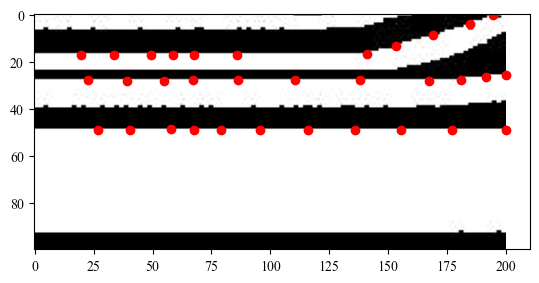

In [51]:
# plot the time space diagram and the keypoint coordinates
plt.imshow(time_space_diagram,cmap = 'gray')
plt.scatter(keypoint_coords[:,0] ,keypoint_coords[:,1] ,c = 'r')
plt.show()